# Analysis of raw non-zero suppressed data
### Non-zero suppressed runs: 8088, 8089

In [1]:
from invisible_cities.cities import components as cp

import numpy as np
import matplotlib.pyplot as plt

### Variables to grab runs

In [2]:
num_files = 3
run_number = 8088
num_plots = 3
data_dir = 'data/trigger1/'+str(run_number)+'/'
file_start = 'run_'+str(run_number)+'_000'
file_end = '_trigger1_waveforms.h5'
files = [data_dir+file_start+str(i+1)+file_end for i in range(0,num_files)]

### Print File Format

In [3]:
i = 0
wfs = cp.wf_from_files(files, cp.WfType.rwf)
try:
    while wfs and i < 1:
        thisdata = next(wfs)
        keys = thisdata.keys()
        print('Keys:', keys)
        for key in keys:
            print(key, type(thisdata[key]))
            print('    ', np.shape(thisdata[key]))
            print('              ', thisdata[key])
        i += 1
except StopIteration:
    pass
finally:
    del wfs

Keys: dict_keys(['pmt', 'sipm', 'run_number', 'event_number', 'timestamp', 'trigger_type', 'trigger_channels'])
pmt <class 'numpy.ndarray'>
     (12, 64000)
               [[3140 3140 3140 ... 3139 3139 3140]
 [3164 3164 3165 ... 3165 3165 3166]
 [3146 3145 3146 ... 3146 3145 3147]
 ...
 [3158 3158 3158 ... 3157 3157 3157]
 [3196 3198 3197 ... 3197 3199 3198]
 [3175 3174 3176 ... 3175 3176 3176]]
sipm <class 'numpy.ndarray'>
     (1792, 1600)
               [[50 65 56 ... 52 54 51]
 [50 53 65 ... 51 52 50]
 [60 53 51 ... 50 52 51]
 ...
 [50 49 49 ... 49 50 49]
 [50 48 60 ... 49 49 48]
 [51 48 48 ... 49 50 49]]
run_number <class 'numpy.int32'>
     ()
               8088
event_number <class 'numpy.int32'>
     ()
               157
timestamp <class 'numpy.uint64'>
     ()
               1594458917438
trigger_type <class 'numpy.int32'>
     ()
               1
trigger_channels <class 'numpy.ndarray'>
     (12,)
               [1 0 1 0 0 0 0 0 0 0 0 0]


### Collect data into numpy array

In [4]:
i = 0
events = []
wfs = cp.wf_from_files(files, cp.WfType.rwf)
try:
    while wfs:
        thisdata = next(wfs)
        events.append(thisdata['sipm'])
        i += 1
except StopIteration:
    pass
finally:
    del wfs
events = np.array(events)
print('Number of Events: '+str(len(events)))

Number of Events: 462


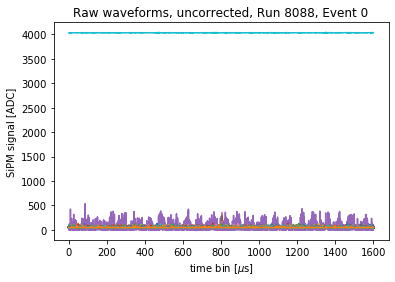

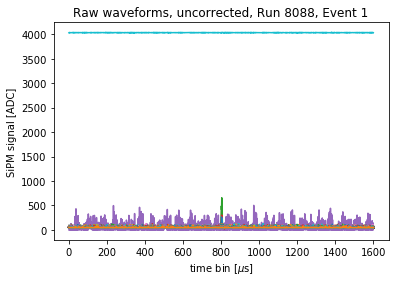

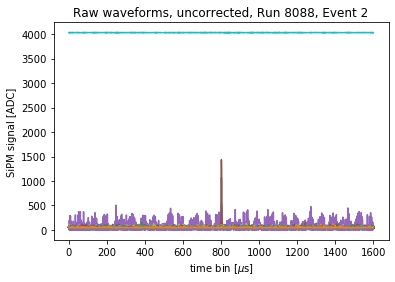

In [5]:
# Plotting a few raw waveforms, without any corrections
for event in range(0,num_plots):
    summed_sipms = np.sum(events[event], axis=1)
    for sipm in events[event]:
        plt.plot(sipm)
    plt.xlabel(r'time bin [$\mu$s]')
    plt.ylabel('SiPM signal [ADC]')
    plt.title('Raw waveforms, uncorrected, Run '+str(run_number)+', Event '+str(event))
    #plt.xlim(640,660)
    #plt.ylim(60000,100000)
    plt.show()

### Finding the noisy SiPMs

In [6]:
pedestals = np.mean(events, axis=2) # shape: (events, sipms)
event_std = np.std(events, axis=2) # shape: (events, sipms)

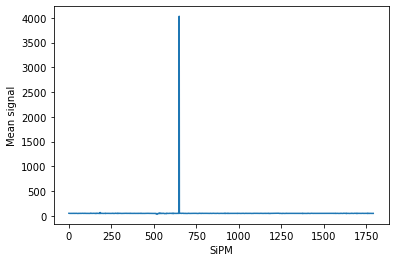

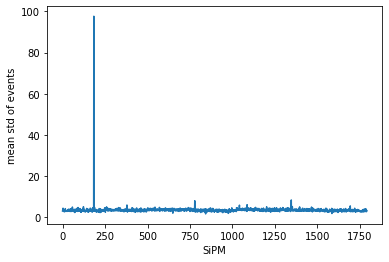

In [7]:
plt.plot(np.mean(pedestals, axis=0))
plt.xlabel('SiPM')
plt.ylabel('Mean signal')
plt.show()

plt.plot(np.mean(event_std, axis=0))
plt.xlabel('SiPM')
plt.ylabel('mean std of events')
plt.show()

In [8]:
bad_sipms = []
for event in range(0,len(events)):
    for sipm in range(len(events[event])):
        mean = np.mean(events[event][sipm])
        std = np.std(events[event][sipm])
        if mean > 70 or std > 70:
            bad_sipms.append(sipm)

worst_sipms = []
for sipm in np.unique(bad_sipms):
    count = np.count_nonzero(bad_sipms == sipm)
    print('SiPM '+str(sipm)+' suspicious in '+str(count)+' events')
    if count == len(events):
        worst_sipms.append(sipm)
print(worst_sipms)

SiPM 184 suspicious in 462 events
SiPM 412 suspicious in 1 events
SiPM 418 suspicious in 1 events
SiPM 649 suspicious in 462 events
SiPM 721 suspicious in 1 events
SiPM 732 suspicious in 1 events
SiPM 794 suspicious in 1 events
[184, 649]


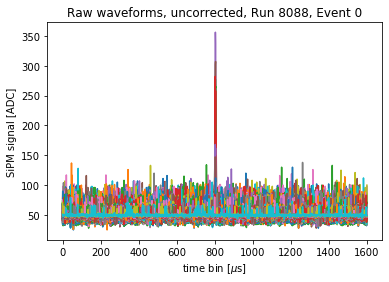

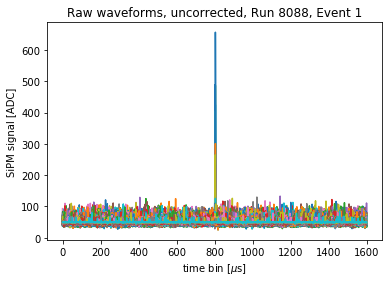

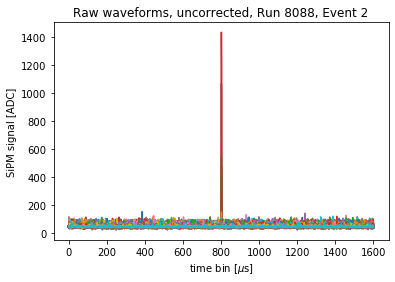

In [9]:
# Plotting a few raw waveforms, without any corrections
for event in range(0,num_plots):
    for sipm in range(len(events[event])):
        if sipm not in worst_sipms:
            plt.plot(events[event][sipm])
    plt.xlabel(r'time bin [$\mu$s]')
    plt.ylabel('SiPM signal [ADC]')
    plt.title('Raw waveforms, uncorrected, Run '+str(run_number)+', Event '+str(event))
    #plt.xlim(640,660)
    #plt.ylim(60000,100000)
    plt.show()

### Find and remove pedestal

In [10]:
#pedestals = np.mean(events, axis=2) # shape: (events, sipms)
events = events - pedestals[:,:,np.newaxis]

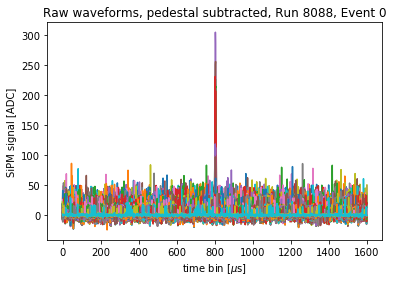

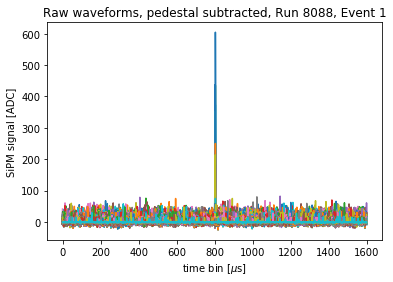

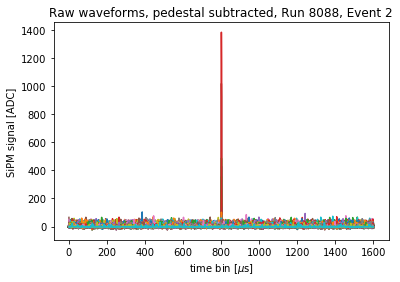

In [11]:
# Plotting a few raw waveforms, pedestal subtracted
for event in range(0,num_plots):
    for sipm in range(len(events[event])):
        if sipm not in worst_sipms:
            plt.plot(events[event][sipm])
    plt.xlabel(r'time bin [$\mu$s]')
    plt.ylabel('SiPM signal [ADC]')
    plt.title('Raw waveforms, pedestal subtracted, Run '+str(run_number)+', Event '+str(event))
    #plt.xlim(640,660)
    #plt.ylim(60000,100000)
    plt.show()

### Determine single pe calibration

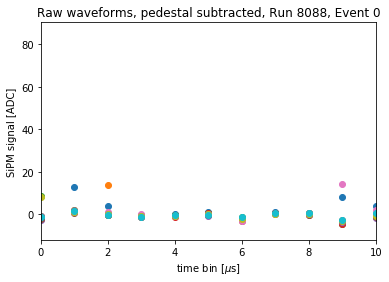

[-1.556875  1.443125 -0.556875 ...  0.443125 17.443125  0.443125]


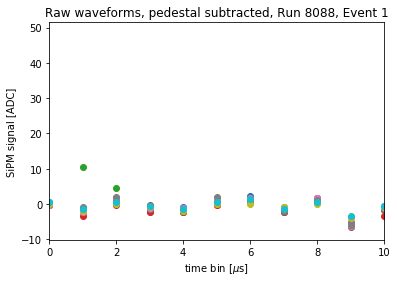

[ 0.5375 -1.4625  0.5375 ... -2.4625 15.5375  2.5375]


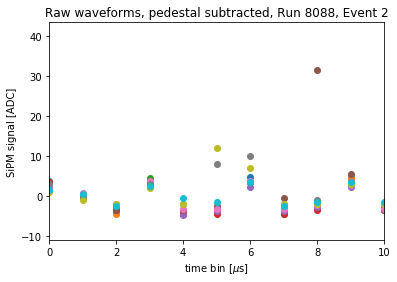

[ 1.43875  0.43875 -2.56125 ...  1.43875 -2.56125  0.43875]


In [12]:
# Plotting a few raw waveforms, pedestal subtracted
for event in range(0,num_plots):
    for sipm in range(0,10):
        if sipm not in worst_sipms:
            plt.plot(events[event][sipm], 'o')
    plt.xlabel(r'time bin [$\mu$s]')
    plt.ylabel('SiPM signal [ADC]')
    plt.title('Raw waveforms, pedestal subtracted, Run '+str(run_number)+', Event '+str(event))
    plt.xlim(0,10)
    #plt.ylim(-10,10)
    plt.show()
    print(events[event][sipm])